In [34]:
import joblib
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from huggingface_hub import notebook_login
import huggingface_hub as hf
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, log_loss, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# import legend
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline


from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt


In [35]:
# Load the data
df = pd.read_csv("/content/hospital_readmission.csv")

In [36]:
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [37]:
df.columns

Index(['age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures',
       'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test',
       'A1Ctest', 'change', 'diabetes_med', 'readmitted'],
      dtype='object')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [39]:
df.rename(columns={'diag_1':'primary_diagnosis','diag_2':'sec_diagnosis',
                       'diag_3':'additional_sec_diag','change':'med_change','A1Ctest':'HbA1ctest'},inplace=True)

df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,primary_diagnosis,sec_diagnosis,additional_sec_diag,glucose_test,HbA1ctest,med_change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [40]:
#converting age column to categorical data
#checking for the unique values in the age column
print(df['age'].unique())

#creating a new column called age_cat
df['age_cat'] = df['age'].replace({'[70-80)':'senior-old age',
                                           '[50-60)':'late-middle age','[60-70)':'mid-old age',
                                           '[40-50)':'early-middle age','[80-90)':'very senior-old','[90-100)':'centenarians'})

print('\n')
#converting column type to categorical data type
df['age_cat'] = df['age_cat'].astype('category')
print('dtype :',df['age_cat'].dtype)

#viewing age and age_cat columns
df[['age','age_cat']]

['[70-80)' '[50-60)' '[60-70)' '[40-50)' '[80-90)' '[90-100)']


dtype : category


,age,age_cat
0,[70-80),senior-old age
1,[70-80),senior-old age
2,[50-60),late-middle age
3,[70-80),senior-old age
4,[60-70),mid-old age
...,...,...
24995,[80-90),very senior-old
24996,[80-90),very senior-old
24997,[70-80),senior-old age
24998,[70-80),senior-old age


In [41]:
#drop age column
df.drop('age', axis=1, inplace=True)

#changing data type to the correct data type
# Columns to be converted to categorical datatype
cols_to_convert = ['medical_specialty', 'primary_diagnosis', 'sec_diagnosis', 'additional_sec_diag', 'glucose_test', 'HbA1ctest', 'med_change', 'diabetes_med', 'readmitted']

# Convert columns to categorical datatype
df[cols_to_convert] = df[cols_to_convert].astype('category')
#checking data type
df.dtypes

,0
time_in_hospital,int64
n_lab_procedures,int64
n_procedures,int64
n_medications,int64
n_outpatient,int64
n_inpatient,int64
n_emergency,int64
medical_specialty,category
primary_diagnosis,category
sec_diagnosis,category


In [42]:
# Complete analysis of the dataset
df.describe()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency
count,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600
std,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873
min,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000
max,14.00000,113.00000,6.000000,79.000000,33.000000,15.000000,64.000000


In [43]:
#describing the categorical columns
df.describe(exclude=[np.number])

,medical_specialty,primary_diagnosis,sec_diagnosis,additional_sec_diag,glucose_test,HbA1ctest,med_change,diabetes_med,readmitted,age_cat
count,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000
unique,7,8,8,8,3,3,2,2,2,6
top,Missing,Circulatory,Other,Other,no,no,no,yes,no,senior-old age
freq,12382,7824,9056,9107,23625,20938,13497,19228,13246,6837


In [44]:
# Checking the unique values in the dataset
df.nunique()

,0
time_in_hospital,14
n_lab_procedures,109
n_procedures,7
n_medications,70
n_outpatient,23
n_inpatient,16
n_emergency,21
medical_specialty,7
primary_diagnosis,8
sec_diagnosis,8


In [45]:
#checking the null value
df.isnull().sum()

,0
time_in_hospital,0
n_lab_procedures,0
n_procedures,0
n_medications,0
n_outpatient,0
n_inpatient,0
n_emergency,0
medical_specialty,0
primary_diagnosis,0
sec_diagnosis,0


In [46]:
# Checking the duplicate values
df.duplicated().sum()

np.int64(0)

In [47]:
#subsetting patient with non-DM diagnosis
non_diabetes_pt = df[~((df['primary_diagnosis'] == 'Diabetes') | (df['sec_diagnosis'] == 'Diabetes') |
    (df['additional_sec_diag'] == 'Diabetes'))]

#subsetting patient with DM diagnosis
diabetes_pt = df[(df['primary_diagnosis'] == 'Diabetes') | (df['sec_diagnosis'] == 'Diabetes') |
    (df['additional_sec_diag'] == 'Diabetes')]

#numbers of non-DM patient
print('number of non-DM patient: ',len(non_diabetes_pt.index))

#numbers of DM patient
print('number of DM patient: ',len(diabetes_pt.index))

number of non-DM patient:  16212
number of DM patient:  8788


readmitted
no     4699
yes    4089
Name: count, dtype: int64


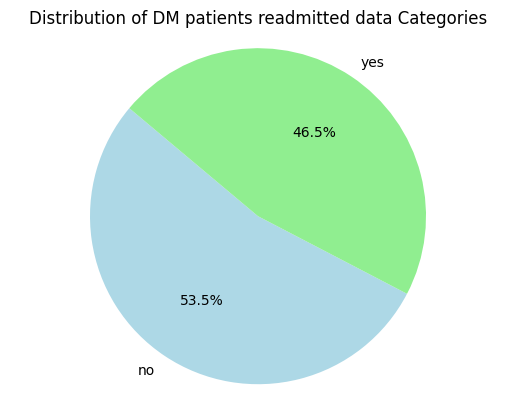

In [48]:
#plotting the distribution of DM patient readmitted data
readmitted_data = diabetes_pt['readmitted'].value_counts(normalize=False).to_dict()

# Create a figure and axis
fig, ax = plt.subplots()

# Data for the pie chart
labels = [f"{status}" for status in readmitted_data.keys()]
sizes = list(readmitted_data.values())

# Colors for the pie chart
colors = ['lightblue', 'lightgreen']

# Plot the pie chart
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Aspect ratio to make the pie circular
ax.axis('equal')

# Title for the pie chart
plt.title('Distribution of DM patients readmitted data Categories')

print(diabetes_pt['readmitted'].value_counts(normalize=False))
# Show the pie chart
plt.show()

readmitted
no     8547
yes    7665
Name: count, dtype: int64


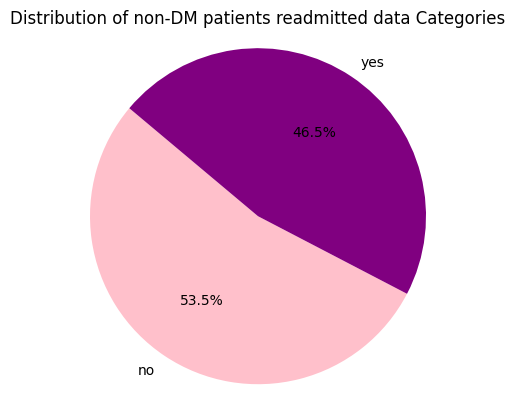

In [49]:
# Create a figure and axis
fig, ax = plt.subplots()

# Data for the pie chart
labels = [f"{status}" for status in readmitted_data.keys()]
sizes = list(readmitted_data.values())

# Colors for the pie chart
colors = ['pink', 'purple']

# Plot the pie chart
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Aspect ratio to make the pie circular
ax.axis('equal')

# Title for the pie chart
plt.title('Distribution of non-DM patients readmitted data Categories')

print(non_diabetes_pt['readmitted'].value_counts(normalize=False))
# Show the pie chart
plt.show()

In [50]:
#table showing the count of readmitted patient for each diagnosis
# pd.set_option('display.max_rows', 64)
df.groupby(['primary_diagnosis','sec_diagnosis','additional_sec_diag'])['readmitted'].count().to_frame().unstack()
# rp.columns = rp.columns.droplevel(0)  # Clean up MultiIndex
# rp.fillna(0, inplace=True)
# rp = rp.astype(int)
# rp

/tmp/ipython-input-2199983630.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['primary_diagnosis','sec_diagnosis','additional_sec_diag'])['readmitted'].count().to_frame().unstack()


readmitted                            \
additional_sec_diag               Circulatory Diabetes Digestive Injury   
primary_diagnosis sec_diagnosis                                           
Circulatory       Circulatory            1724      877        48     66   
                  Diabetes                394       28        12      8   
                  Digestive                26        6        10      0   
                  Injury                   70       21         3     14   
                  Missing                   3        0         0      0   
...                                       ...      ...       ...    ...   
Respiratory       Injury                    7        2         0      2   
                  Missing                   0        1         0      0   
                  Musculoskeletal           8       11         1      0   
                  Other                   247      196        17     14   
                  Respiratory             293      180        16     11   

                                                                             
additional_sec_diag               Missing Musculoskeletal Other Respiratory  
primary_diagnosis sec_diagnosis                                              
Circulatory       Circulatory           2              25   958         366  
                  Diabetes             20              11   331          35  
                  Digestive             0               1    31           4  
                  Injury                0               0    40           6  
                  Missing               0               0     2           0  
...                                   ...             ...   ...         ...  
Respiratory       Injury                0               0     8           4  
                  Missing               0               0     0           0  
                  Musculoskeletal       0               5    13           8  
                  Other                 1              15   358         108  
                  Respiratory           0              10   254         137  

[64 rows x 8 columns]

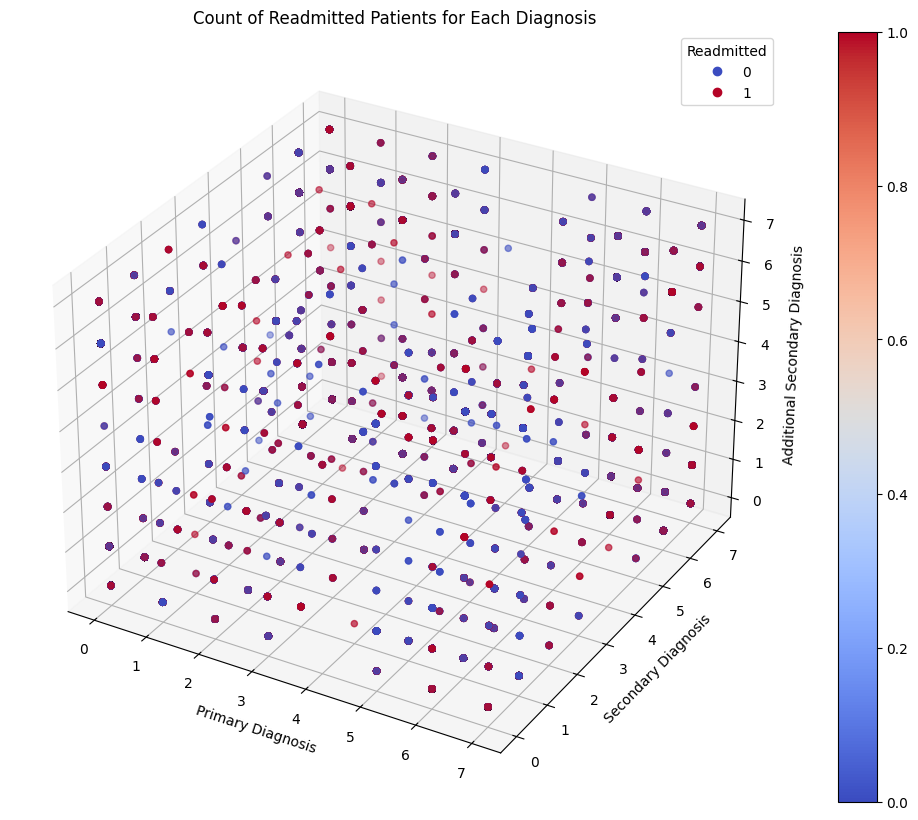

In [27]:
# Map 'yes' to 1 and 'no' to 0 in the 'readmitted' column
es = df['readmitted'].map({'yes': 1, 'no': 0})

# Convert categorical data to numeric codes
x = df['primary_diagnosis'].cat.codes
y = df['sec_diagnosis'].cat.codes
z = df['additional_sec_diag'].cat.codes

# Set color based on 'readmitted' column
c = es

# Adjust the figure size for better viewing
fig = plt.figure(figsize=(15, 10))

# Create a 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D heatmap
img = ax.scatter(x, y, z, c=c, cmap='coolwarm', marker='o')

# Add a color bar
fig.colorbar(img)

# Set axis labels
ax.set_xlabel('Primary Diagnosis')
ax.set_ylabel('Secondary Diagnosis')
ax.set_zlabel('Additional Secondary Diagnosis')

# Set title
plt.title('Count of Readmitted Patients for Each Diagnosis')

# Position legend outside the plot
plt.legend(*img.legend_elements(), title='Readmitted')

# Show the 3D heatmap
plt.show()

In [ ]:
#viewing the dataset
df.head()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,primary_diagnosis,sec_diagnosis,additional_sec_diag,glucose_test,HbA1ctest,med_change,diabetes_med,readmitted,age_cat
0,8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no,senior-old age
1,3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no,senior-old age
2,5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes,late-middle age
3,2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes,senior-old age
4,1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no,mid-old age


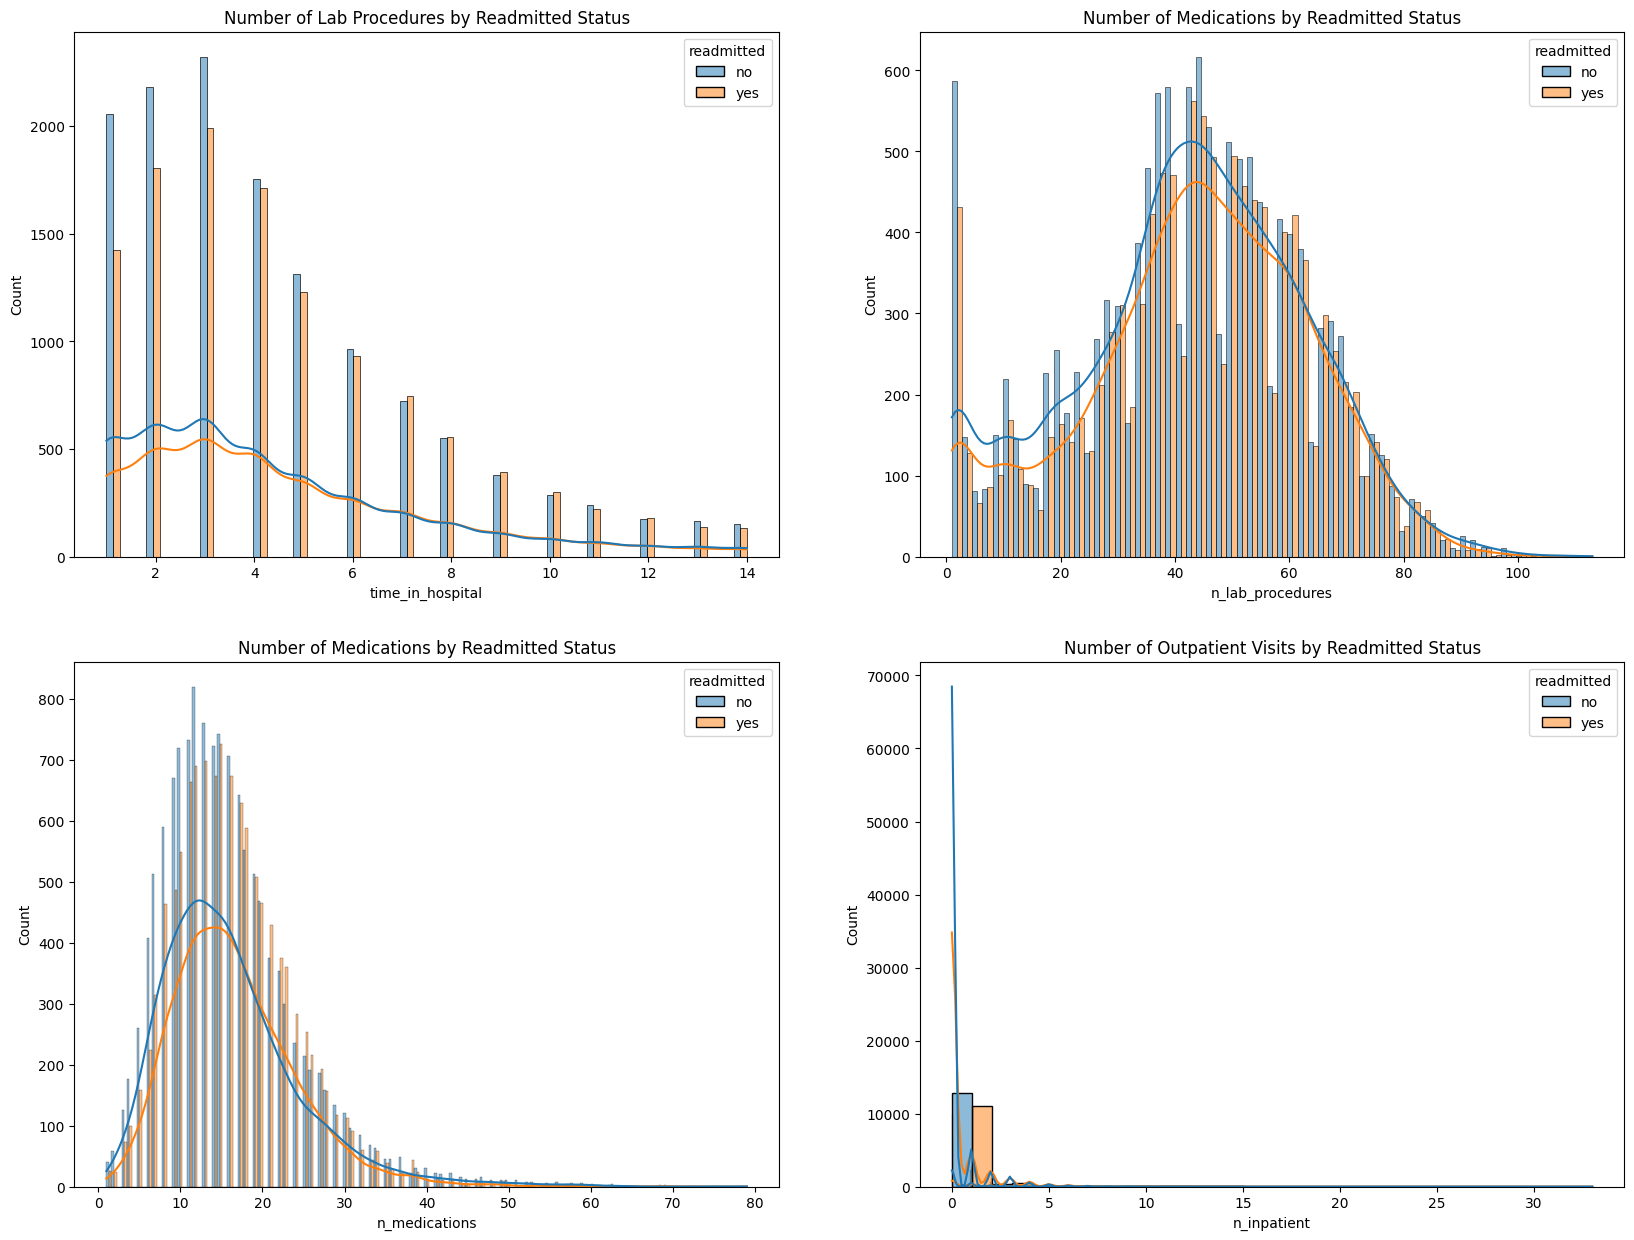

In [28]:
#plotting a grap showing the distribution of numerical columns by their readmitted status
# Create a figure and axis
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Plot the distribution of 'time_in_hospital' by 'readmitted' status
sns.histplot(df, x='time_in_hospital', hue='readmitted', multiple='dodge',kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Number of Lab Procedures by Readmitted Status')

# Plot the distribution of 'n_lab_procedures' by 'readmitted' status
sns.histplot(df, x='n_lab_procedures', hue='readmitted', multiple='dodge',kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Number of Medications by Readmitted Status')

# Plot the distribution of 'n_medications' by 'readmitted' status
sns.histplot(df, x='n_medications', hue='readmitted', multiple='dodge',kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Number of Medications by Readmitted Status')

# Plot the distribution of 'n_inpatient' by 'readmitted' status
sns.histplot(df, x='n_inpatient', hue='readmitted', multiple='dodge',kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Number of Inpatient Visits by Readmitted Status')

# plot the distribution of 'n_outpatient' by 'readmitted' status
sns.histplot(df, x='n_outpatient', hue='readmitted', multiple='dodge',kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Number of Outpatient Visits by Readmitted Status')

# Show the plots
plt.show()

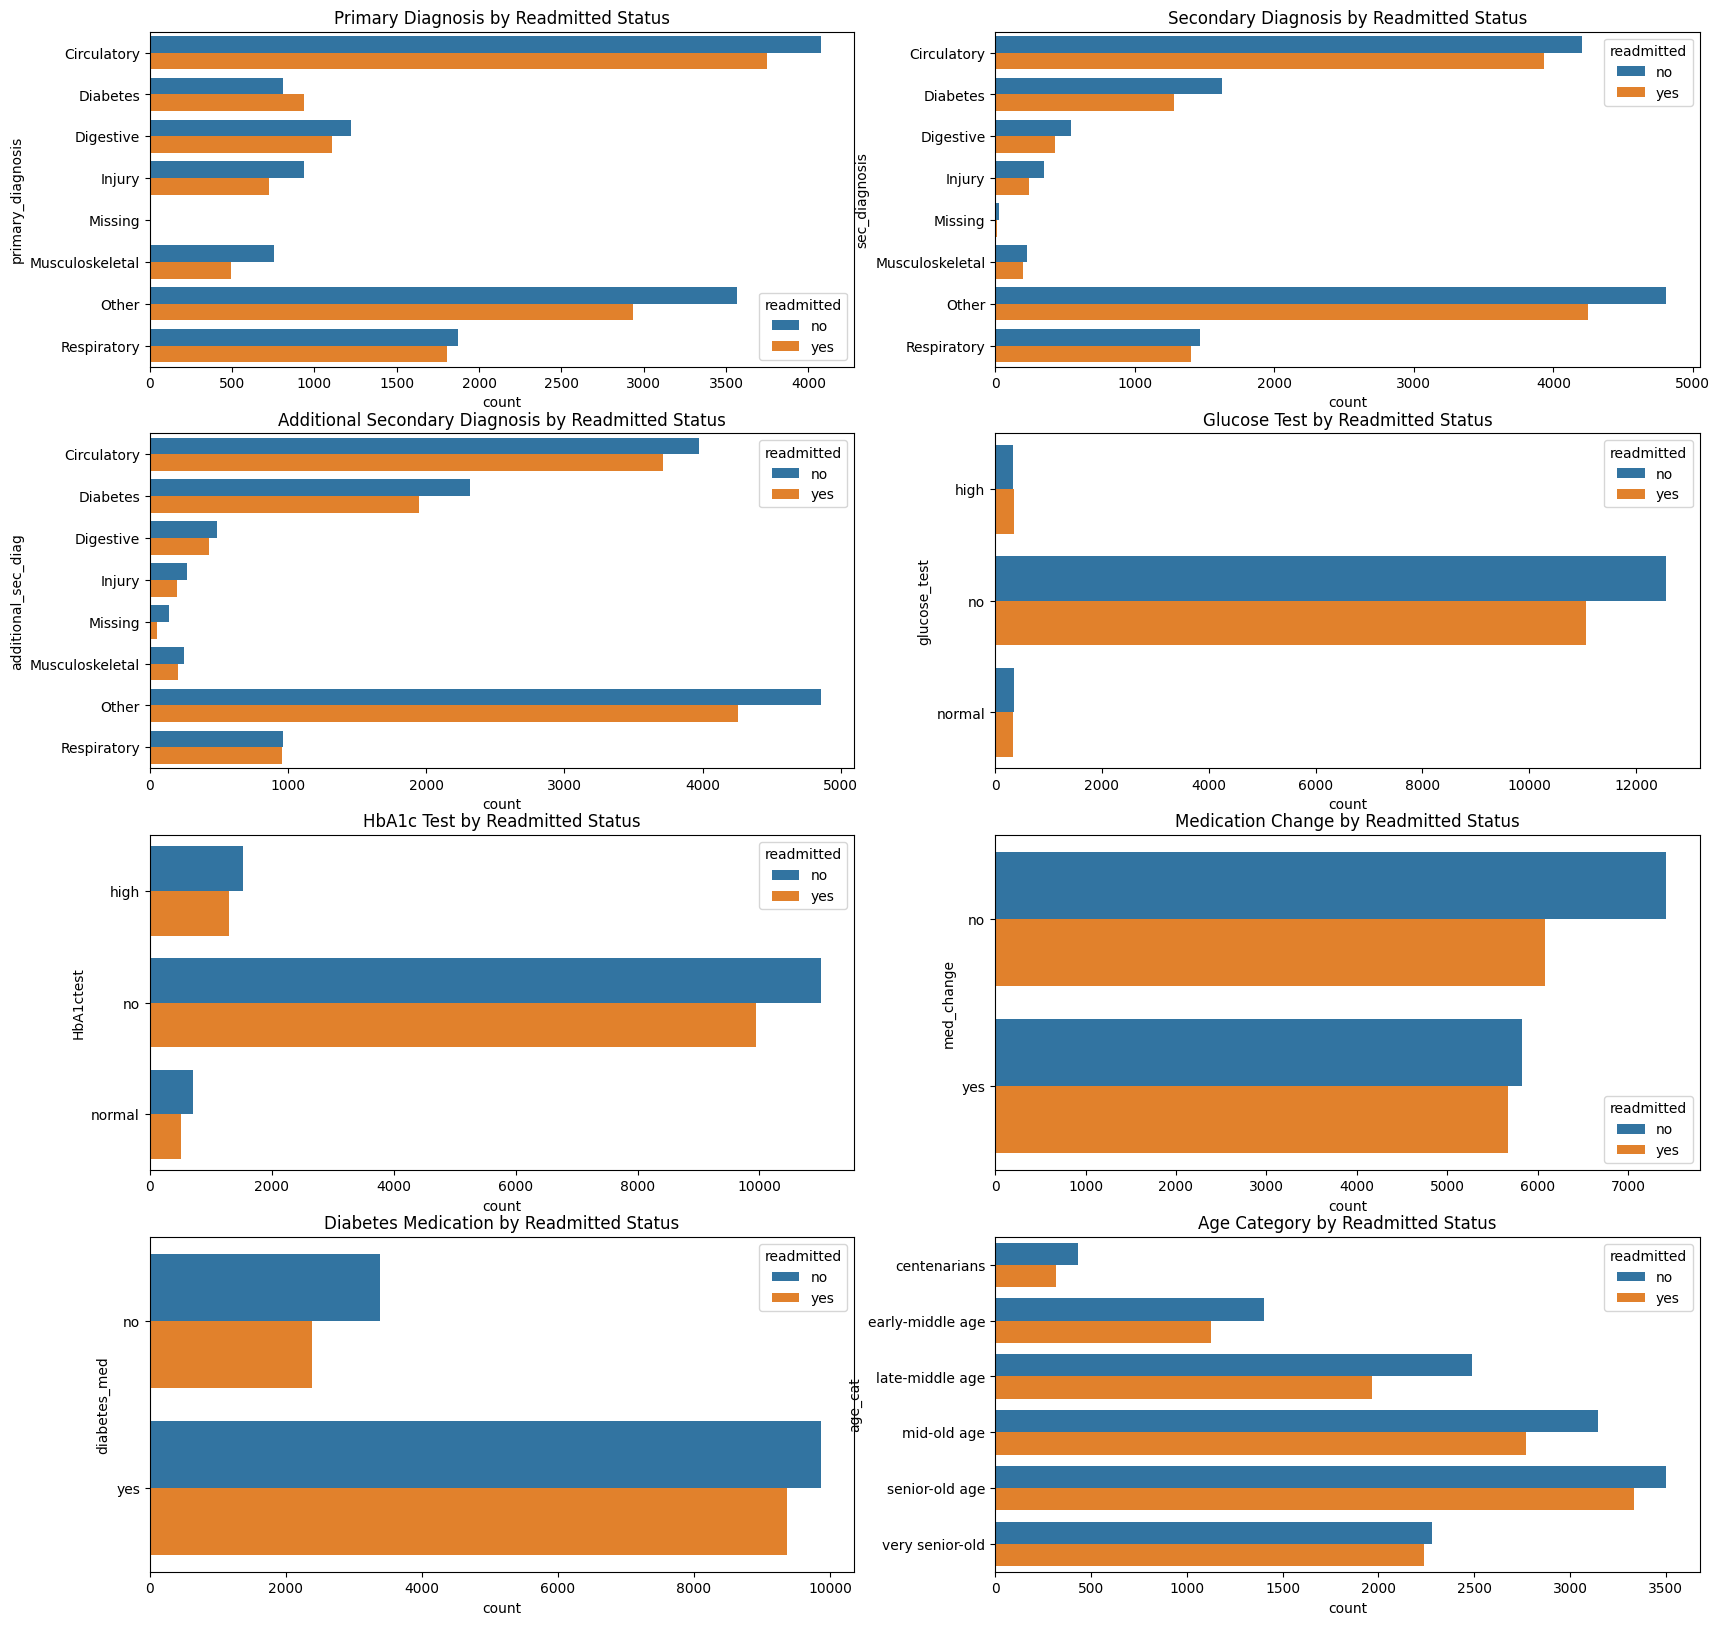

In [52]:
#visualizing the categorical columns by thier readmitted status

# Create a figure and axis
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Plot the distribution of 'primary_diagnosis' by 'readmitted' status
sns.countplot(y='primary_diagnosis', hue='readmitted', data=df, ax=ax[0, 0])
ax[0, 0].set_title('Primary Diagnosis by Readmitted Status')

# Plot the distribution of 'sec_diagnosis' by 'readmitted' status
sns.countplot(y='sec_diagnosis', hue='readmitted', data=df, ax=ax[0, 1])
ax[0, 1].set_title('Secondary Diagnosis by Readmitted Status')

# Plot the distribution of 'additional_sec_diag' by 'readmitted' status
sns.countplot(y='additional_sec_diag', hue='readmitted', data=df, ax=ax[1, 0])
ax[1, 0].set_title('Additional Secondary Diagnosis by Readmitted Status')

# Plot the distribution of 'glucose_test' by 'readmitted' status
sns.countplot(y='glucose_test', hue='readmitted', data=df, ax=ax[1, 1])
ax[1, 1].set_title('Glucose Test by Readmitted Status')

# Plot the distribution of 'HbA1ctest' by 'readmitted' status
sns.countplot(y='HbA1ctest', hue='readmitted', data=df, ax=ax[2, 0])
ax[2, 0].set_title('HbA1c Test by Readmitted Status')

# Plot the distribution of 'med_change' by 'readmitted' status
sns.countplot(y='med_change', hue='readmitted', data=df, ax=ax[2, 1])
ax[2, 1].set_title('Medication Change by Readmitted Status')

# Plot the distribution of 'diabetes_med' by 'readmitted' status
sns.countplot(y='diabetes_med', hue='readmitted', data=df, ax=ax[3, 0])
ax[3, 0].set_title('Diabetes Medication by Readmitted Status')

# Plot the distribution of 'age_cat' by 'readmitted' status
sns.countplot(y='age_cat', hue='readmitted', data=df, ax=ax[3, 1])
ax[3, 1].set_title('Age Category by Readmitted Status')

# Show the plots
plt.show()

In [53]:
# convert categorical columns to numerical columns using label encoding
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Apply the LabelEncoder to the categorical columns
df['medical_specialty'] = le.fit_transform(df['medical_specialty'])
df['primary_diagnosis'] = le.fit_transform(df['primary_diagnosis'])
df['sec_diagnosis'] = le.fit_transform(df['sec_diagnosis'])
df['additional_sec_diag'] = le.fit_transform(df['additional_sec_diag'])
df['age_cat'] = le.fit_transform(df['age_cat'])
df['glucose_test'] = le.fit_transform(df['glucose_test'])
df['HbA1ctest'] = le.fit_transform(df['HbA1ctest'])
df['med_change'] = le.fit_transform(df['med_change'])
df['diabetes_med'] = le.fit_transform(df['diabetes_med'])
df['readmitted'] = le.fit_transform(df['readmitted'])


#viewing the dataset
df.head()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,primary_diagnosis,sec_diagnosis,additional_sec_diag,glucose_test,HbA1ctest,med_change,diabetes_med,readmitted,age_cat
0,8,72,1,18,2,0,0,4,0,7,6,1,1,0,1,0,4
1,3,34,2,13,0,0,0,5,6,6,6,1,1,0,1,0,4
2,5,45,0,18,0,0,0,4,0,0,0,1,1,1,1,1,2
3,2,36,0,12,1,0,0,4,0,6,1,1,1,1,1,1,4
4,1,42,0,7,0,0,0,3,6,0,7,1,1,0,1,0,3


In [54]:
# Select columns for clustering
quantCols = df.select_dtypes(include=[int,float]).columns

# Create new DataFrame with clustering variables
df_features = df[quantCols]

df_features

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,primary_diagnosis,sec_diagnosis,additional_sec_diag,glucose_test,HbA1ctest,med_change,diabetes_med,readmitted,age_cat
0,8,72,1,18,2,0,0,4,0,7,6,1,1,0,1,0,4
1,3,34,2,13,0,0,0,5,6,6,6,1,1,0,1,0,4
2,5,45,0,18,0,0,0,4,0,0,0,1,1,1,1,1,2
3,2,36,0,12,1,0,0,4,0,6,1,1,1,1,1,1,4
4,1,42,0,7,0,0,0,3,6,0,7,1,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14,77,1,30,0,0,0,4,0,6,0,1,2,0,0,1,5
24996,2,66,0,24,0,0,0,4,2,3,6,1,0,1,1,1,5
24997,5,12,0,6,0,1,0,4,6,6,6,2,1,0,0,1,4
24998,2,61,3,15,0,0,0,2,7,1,6,1,1,1,1,0,4


In [55]:
#Transforming all colimns that have noticeable skewness
transformCols = ['time_in_hospital','n_lab_procedures','n_procedures',
                 'n_medications','n_outpatient','n_inpatient','n_emergency']
all([pd.api.types.is_numeric_dtype(df_features[col]) for col in transformCols])

True

In [56]:
df_log = df_features.copy()
# Perform a log transformation of the data to unskew the data
for feat in transformCols:
    #Add one to avoid INF values
    df_log[feat] = np.log(1+df_features[feat])

#Check how many INF readings we have in the data
np.isinf(df_log).sum()

,0
time_in_hospital,0
n_lab_procedures,0
n_procedures,0
n_medications,0
n_outpatient,0
n_inpatient,0
n_emergency,0
medical_specialty,0
primary_diagnosis,0
sec_diagnosis,0


In [57]:
#Change INF values to mean for each feature
for i in transformCols:
    df_log[i].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_log[i] = df_log[i].fillna(df_log[i].mean())

np.isinf(df_log).sum()

/tmp/ipython-input-839970731.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_log[i].replace([np.inf, -np.inf], np.nan, inplace=True)


,0
time_in_hospital,0
n_lab_procedures,0
n_procedures,0
n_medications,0
n_outpatient,0
n_inpatient,0
n_emergency,0
medical_specialty,0
primary_diagnosis,0
sec_diagnosis,0


In [58]:
# import make_pipeline
from sklearn.pipeline import make_pipeline
# Instantiate StandardScaler, PCA as scaler and pca respectively
scaler = StandardScaler()
pca = PCA()
# Create the pipeline using scaler and the pca object
pipeline = make_pipeline(scaler, pca)

# Fit and transform the model
df_normalized = pipeline.fit_transform(df_log)
df_normalized.shape

(25000, 17)

In [59]:
# Convert categorical columns to numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate the variance of numerical columns
variance = df_numeric.var()

variance

,0
time_in_hospital,9.008821
n_lab_procedures,392.777706
n_procedures,2.941840
n_medications,64.972173
n_outpatient,1.429168
n_inpatient,1.387569
n_emergency,0.784772
medical_specialty,2.031904
primary_diagnosis,7.996343
sec_diagnosis,8.488636


In [60]:
df_processed = pd.DataFrame(
    data=df_normalized, index=df_log.index, columns=df_log.columns
)
df_processed['readmitted'] = df_features['readmitted']

In [61]:
# Convert categorical columns to numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate the variance of numerical columns
variance = df_numeric.var()

variance


,0
time_in_hospital,9.008821
n_lab_procedures,392.777706
n_procedures,2.941840
n_medications,64.972173
n_outpatient,1.429168
n_inpatient,1.387569
n_emergency,0.784772
medical_specialty,2.031904
primary_diagnosis,7.996343
sec_diagnosis,8.488636


In [62]:
# Split the data into two DataFrames: X (features) and y (target variable)
X = df_processed.drop(columns=['readmitted'],axis=1)  # Specify at least one column as a feature
y = df_processed["readmitted"]  # Specify one column as the target variable

# Split the data into train and test subsets
# You can adjust the test size and random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.275, random_state=123
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18124, 16), (6876, 16), (18124,), (6876,))

In [63]:
# Dictionaries to store metrics
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "AUC-ROC": []
}

In [64]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "n_estimators": 97,  # Number of trees in the forest
    "max_depth": 10,  # Max depth of the tree
    "min_samples_split": 3,  # Min number of samples required to split a node
    "min_samples_leaf": 1,  # Min number of samples required at a leaf node
    "ccp_alpha": 0,  # Cost complexity parameter for pruning
    "random_state": 123,
}
#{'n_estimators': 97, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 10, 'ccp_alpha': 0}

# Create a RandomForestRegressor object with the parameters above
rf = RandomForestClassifier(**params)

# Train the random forest on the train set
rf = rf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = rf.predict(X_test)

In [65]:
y_pred = rf.predict(X_test)
print('Training Set:', rf.score(X_train,y_train))
print('Test Set:', rf.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))



Training Set: 1.0
Test Set: 0.9968004653868529
Accuracy: 99.68%
Precision: 99.47%
Recall: 99.84%
Area Under the Curve: 99.69%


In [66]:
scores = cross_val_score(rf, X_test, y_test, error_score="raise", cv=5, verbose=True)
scores

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s finished


array([0.99709302, 0.99636364, 0.992     , 0.99418182, 0.99636364])

In [67]:
# Define a parameter grid with distributions of possible parameters to use
rs_param_grid = {
    "n_estimators": list((range(20, 200))),
    "max_depth": list((range(3, 15))),
    "min_samples_split": list((range(2, 5))),
    "min_samples_leaf": list((range(1, 5))),
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
}

# Create a RandomForestRegressor
rf = RandomForestClassifier(random_state=123)

# Instantiate RandomizedSearchCV() with rf and the parameter grid
rf_rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rs_param_grid,
    cv=3,  # Number of folds
    n_iter=10,  # Number of parameter candidate settings to sample
    verbose=1,  # The higher this is, the more messages are outputed
    scoring="accuracy",  # Metric to evaluate performance
    random_state=123
)

# Train the model on the training set
rf_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", rf_rs.best_params_)
print("Best performance: ", rf_rs.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 121, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 13, 'ccp_alpha': 0}
Best performance:  0.9970757220196544


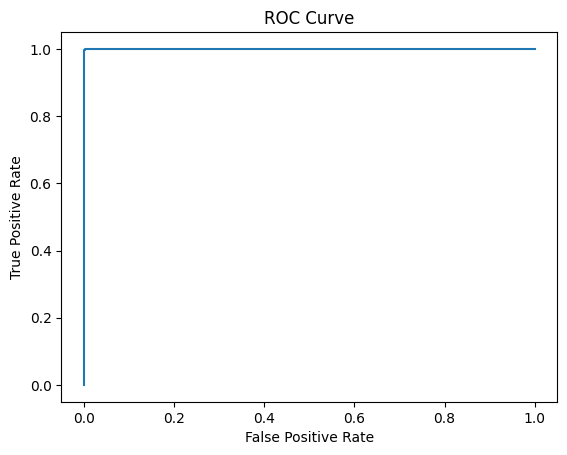

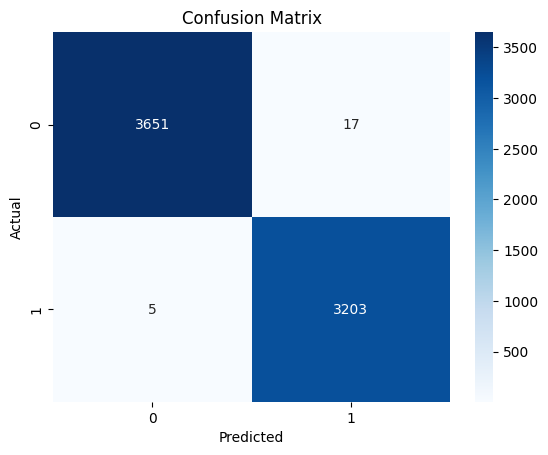

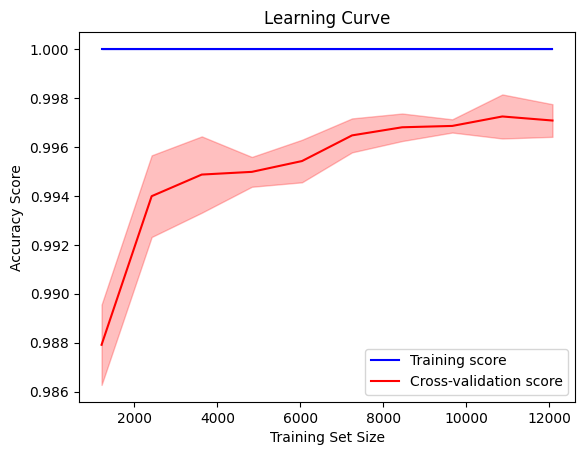

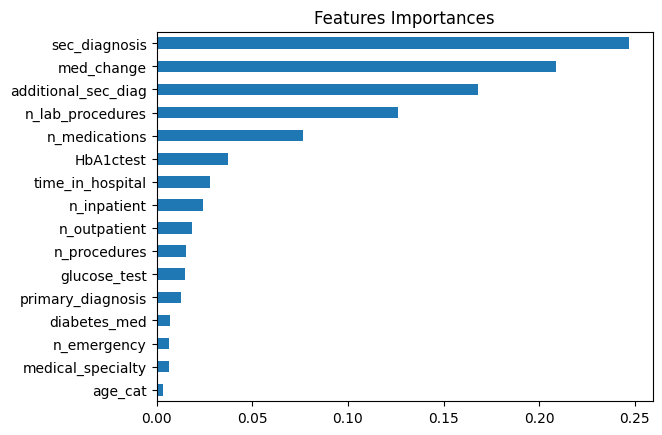

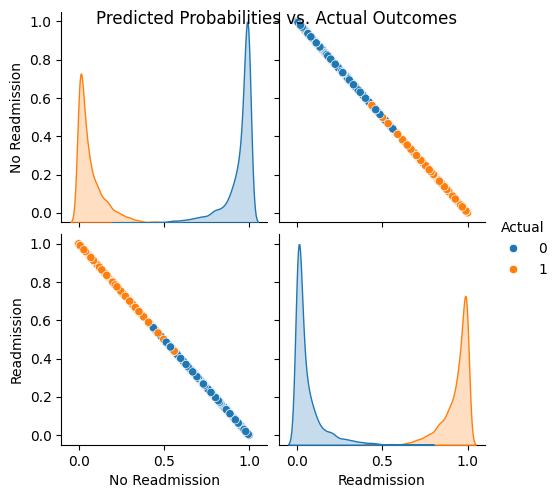

0.07096255924518906

In [68]:
from sklearn.model_selection import learning_curve
# ploting the ROC curve of the fine-tuned model
# Get the predicted probabilities

y_pred_proba = rf_rs.predict_proba(X_test)[:, 1]

# Calculate the fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Calculate the AUC-ROC score
roc_auc_score(y_test, y_pred_proba)

#plotting the confusion matrix
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#plotting the learning curve
# Create a learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_rs.best_estimator_,
    X=X_train,
    y=y_train,
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

# Calculate the mean and standard deviation of the training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate the mean and standard deviation of the test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.fill_between(
    train_sizes, train_mean + train_std, train_mean - train_std, color="blue", alpha=0.25
)
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="red")
plt.fill_between(
    train_sizes, test_mean + test_std, test_mean - test_std, color="red", alpha=0.25
)
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")

plt.legend()
plt.show()

#plotting the feature importance
# Create a sorted Series of features importances
importances_sorted = pd.Series(
    data=rf_rs.best_estimator_.feature_importances_, index=X_train.columns
).sort_values()

# Plot a horizontal barplot of importances_sorted
importances_sorted.plot(kind="barh")
plt.title("Features Importances")
plt.show()

#plotting the data distribution
# Create a DataFrame with the predicted probabilities
df_pred = pd.DataFrame(
    data=rf_rs.predict_proba(X_test), columns=["No Readmission", "Readmission"]
)

# Create a DataFrame with the actual outcomes
df_actual = pd.DataFrame(data=y_test.values, columns=["Actual"])

# Concatenate the DataFrames
df_pred_actual = pd.concat([df_pred, df_actual], axis=1)

# Create a pairplot of the predicted probabilities and actual outcomes
sns.pairplot(df_pred_actual, hue="Actual")
plt.suptitle("Predicted Probabilities vs. Actual Outcomes")
plt.show()

#plotting the data loss
# Calculate the log loss
log_loss(y_test, rf_rs.predict_proba(X_test))

In [69]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "n_neighbors": 20
}

# Create a logistic regression classifier object with the parameters above
knn1 = KNeighborsClassifier(**params)

# Train the classifer on the train set
knn1 = knn1.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = knn1.predict(X_test)
print('Training Set:', knn1.score(X_train,y_train))
print('Test Set:', knn1.score(X_test,y_test))

Training Set: 0.9987861399249613
Test Set: 0.9982547993019197


In [70]:
# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))

Accuracy: 99.83%
Precision: 99.88%
Recall: 99.75%
Area Under the Curve: 99.82%


In [71]:
scores = cross_val_score(knn1, X_test, y_test, error_score="raise", cv=5, verbose=True)
scores

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


array([0.99636628, 0.99563636, 0.992     , 0.99272727, 0.99781818])

In [72]:
#Dimensionality Reduction
#Doing dimensionality reduction so that logit model doesn't reach perfect separation

dropCols = ['n_medications',
            'n_procedures',
            'time_in_hospital',
            #'n_inpatient',
            #'n_lab_procedures',
            # 'n_emergency',
            'n_outpatient',
            'glucose_test',
            'HbA1ctest',
            'primary_diagnosis',
            'sec_diagnosis',
            'additional_sec_diag',
            ]

df_reduced = df_processed.copy()

for i in dropCols:
    df_reduced.drop(columns = [i], axis=1, inplace=True)

df_reduced

,n_lab_procedures,n_inpatient,n_emergency,medical_specialty,med_change,diabetes_med,readmitted,age_cat
0,-0.172495,0.248465,0.203812,-0.688642,0.112696,0.543698,0,-0.190140
1,-0.332913,0.143652,-0.092448,-0.123051,-0.332256,-1.080019,0,-0.219143
2,-0.667454,0.259349,0.141247,-0.078741,-0.485166,1.381247,1,0.266583
3,0.752202,1.255505,0.239219,-0.713521,-0.549648,0.202464,1,0.166202
4,0.149367,-0.159277,-0.289648,0.385360,-0.187185,-0.804869,0,0.056043
...,...,...,...,...,...,...,...,...
24995,-1.150638,2.107975,-0.562831,1.100951,-0.821627,1.418165,1,0.528352
24996,-0.021687,0.690001,0.641990,-1.718390,-0.906515,-0.548689,1,1.345502
24997,1.739487,0.867392,3.555594,1.150893,0.519946,0.705016,1,-0.641256
24998,-0.975286,0.194593,-0.151786,0.852001,-0.350052,-1.750349,0,-0.296373


In [73]:
df_reduced.describe()

,n_lab_procedures,n_inpatient,n_emergency,medical_specialty,med_change,diabetes_med,readmitted,age_cat
count,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,25000.000000,2.500000e+04
mean,-1.158185e-17,1.428191e-17,-5.080381e-18,1.378453e-17,6.039613e-18,-1.875833e-17,0.470160,1.302070e-17
std,1.264993e+00,1.033197e+00,9.962024e-01,9.745738e-01,8.401726e-01,7.736185e-01,0.499119,6.767548e-01
min,-3.408176e+00,-4.866598e+00,-4.751907e+00,-4.381262e+00,-6.424905e+00,-2.878326e+00,0.000000,-3.935941e+00
25%,-8.360667e-01,-6.979272e-01,-2.318257e-01,-5.117708e-01,-5.165666e-01,-5.235238e-01,0.000000,-4.216219e-01
50%,-6.577342e-02,6.961046e-02,-3.286670e-02,2.174802e-02,-3.466400e-02,-1.628356e-02,0.000000,3.337854e-02
75%,7.092002e-01,7.691540e-01,1.925700e-01,5.457565e-01,4.281903e-01,5.028886e-01,1.000000,4.582158e-01
max,9.277440e+00,2.906131e+00,5.071992e+00,3.884851e+00,3.423140e+00,3.582854e+00,1.000000,2.352901e+00


In [74]:
# Split the data into two DataFrames: X (features) and y (target variable)
X = df_reduced.drop(columns=['readmitted'],axis=1)  # Specify at least one column as a feature
y = df_reduced["readmitted"]  # Specify one column as the target variable

# Split the data into train and test subsets
# You can adjust the test size and random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18750, 7), (6250, 7), (18750,), (6250,))

                       coef
n_lab_procedures   0.920450
n_inpatient        0.434738
n_emergency       -0.071505
medical_specialty -0.112074
med_change        -1.061884
diabetes_med       0.015039
age_cat           -0.032635


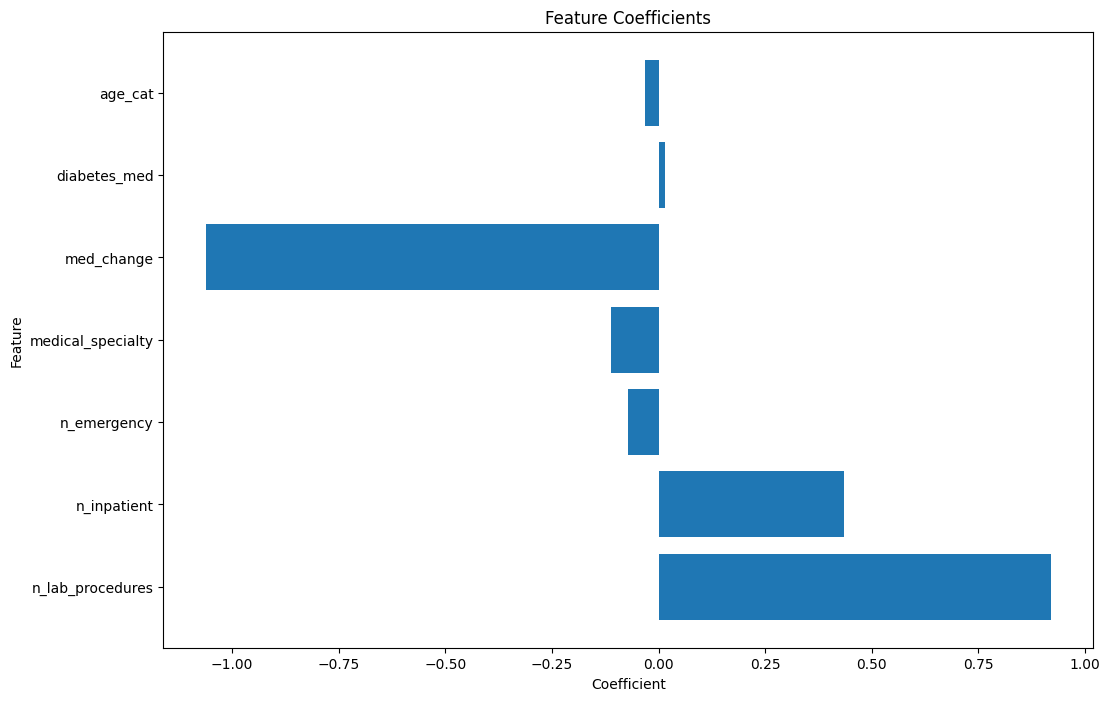

In [75]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "penalty": "l2",  # Norm of the penalty: 'l1', 'l2', 'elasticnet', 'none'
    #"C": 1,  # Inverse of regularization strength, a positive float
    "random_state": 123,
}

# Create a logistic regression classifier object with the parameters above
clf = LogisticRegression(**params)

# Train the classifer on the train set
clf = clf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = clf.predict(X_test)
df_coef = pd.DataFrame(data=clf.coef_[0])

df_coef = df_coef.set_index(np.array(clf.feature_names_in_))
df_coef.rename(columns={0: 'coef'},inplace=True)
df_coef.sort_values('coef')

print(df_coef)

# Graph of the coefficients
plt.figure(figsize=(12, 8))
plt.barh(df_coef.index, df_coef['coef'])
plt.title('Feature Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

In [76]:
print('Training Set:', clf.score(X_train,y_train))
print('Test Set:', clf.score(X_test,y_test))

Training Set: 0.7453866666666666
Test Set: 0.74736


In [77]:
# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))

Accuracy: 74.74%
Precision: 74.94%
Recall: 69.28%
Area Under the Curve: 74.42%


In [78]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report

# --- Random Forest Classifier (on reduced features) ---
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=97,
    max_depth=10,
    min_samples_split=3,
    min_samples_leaf=1,
    ccp_alpha=0.0,
    random_state=123,
    n_jobs=-1
)

# Cross-validation scores
rf_scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
rf_mean_acc = rf_scores.mean()

# Cross-validated predictions
rf_y_pred = cross_val_predict(rf_model, X, y, cv=10)

print("Model: Random Forest")
print("Mean Accuracy:", f"{rf_mean_acc:.2f}")
print("Scores:", rf_scores)
print(classification_report(y, rf_y_pred))


# --- LightGBM Classifier (on reduced features) ---
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=123
)

# Cross-validation scores
lgbm_scores = cross_val_score(lgbm_model, X, y, cv=10, scoring='accuracy')
lgbm_mean_acc = lgbm_scores.mean()

# Cross-validated predictions
lgbm_y_pred = cross_val_predict(lgbm_model, X, y, cv=10)

print("\nModel: LightGBM")
print("Mean Accuracy:", f"{lgbm_mean_acc:.2f}")
print("Scores:", lgbm_scores)
print(classification_report(y, lgbm_y_pred))


Model: Random Forest
Mean Accuracy: 0.85
Scores: [0.8624 0.8576 0.8496 0.8504 0.838  0.844  0.8452 0.848  0.8604 0.8496]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     13246
           1       0.85      0.82      0.84     11754

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

[LightGBM] [Info] Number of positive: 10579, number of negative: 11921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 22500, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470178 -> initscore=-0.119431
[LightGBM] [Info] Start training from score -0.119431
[LightGBM] [Info] Number of positive: 10579, number of nega

In [79]:
lgbm_model.fit(X, y)  # fit on full data before saving
joblib.dump(lgbm_model, "model_crossval_lightgbm.pkl")

print("\nLightGBM model saved as model_crossval_lightgbm.pkl")

[LightGBM] [Info] Number of positive: 11754, number of negative: 13246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470160 -> initscore=-0.119502
[LightGBM] [Info] Start training from score -0.119502

LightGBM model saved as model_crossval_lightgbm.pkl
